# Neural Network from scratch and with Tensorflow

In this jupyter notebook the goal was to get a better understanding of a neural network and build a model with numpy. After that different neural networks were build with Tensorflow and stepwise improved. 

## Import of the necessary libraries

In [45]:
import os
import numpy as np
import sys
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard

import matplotlib.pyplot as plt


print(tf.__version__)
print(np.__version__)
print(sys.version)

2.7.0
1.21.4
3.9.1 (tags/v3.9.1:1e5d33e, Dec  7 2020, 17:08:21) [MSC v.1927 64 bit (AMD64)]


## Set directory 

In [4]:
DATADIR = "C:/Users/Lars Hubacher/Desktop/HSLU/Master/Unterrichtsunterlagen/3_Semester/Deep_learning_in_vision/data/output/train"

VALDIR = "C:/Users/Lars Hubacher/Desktop/HSLU/Master/Unterrichtsunterlagen/3_Semester/Deep_learning_in_vision/data/output/val"

CATEGORIES = ["Defect", "No Defect"]

In [3]:
## Image size
IMG_SIZE = 150

In [4]:
## Empty lists for Training and Validation data
training_data = []
validation_data = []

In [5]:
## Create arrays out of the pictures
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_UNCHANGED)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except Exception as e:
                print(Exception)

In [136]:
## Create arrays out of the pictures
def create_validation_data():
    for category in CATEGORIES:
        path = os.path.join(VALDIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_UNCHANGED)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                validation_data.append([new_array, class_num])
            except Exception as e:
                print(Exception)

In [137]:
create_training_data()
create_validation_data()

In [138]:
## Shuffle the data
import random

random.shuffle(training_data)
random.shuffle(validation_data)

In [139]:
X_train = []
y_train = []

In [140]:
## Get the labels for the data "Defect" and "No Defect"
for features, label in training_data:
    X_train.append(features)
    y_train.append(label)

In [141]:
X_val = []
y_val = []

In [142]:
## Get the labels for the data "Defect" and "No Defect"
for features, label in validation_data:
    X_val.append(features)
    y_val.append(label)

In [143]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

In [144]:
X_train = X_train[:,:,:,0:3]/255
X_val = X_val[:,:,:,0:3]/255

## Basic NN1 with numpy

A first model is build with the following properties.

* Tanh activation function for hidden layer
* Softmax function in the output layer
* alpha = 2
* iterations = 100
* hidden_size = 100
* pixels_per_image = 150 * 150 * 3
* num_labels = 2
* batch_size = 100

In [166]:
images = X_train.reshape(len(X_train), 150*150*3)
print(images.shape)
labels = y_train

one_hot_labels = np.zeros((len(labels), 2)) ## array mit 2412 rows and 2 columns

for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1 ## Defect 0,1, No Defect 1,0
labels = one_hot_labels ## The arrays are taken from on_hot_labels

val_images = X_val.reshape(len(X_val), 150*150*3)
val_labels = np.zeros((len(y_val), 2))
for i,l in enumerate(y_val):
    val_labels[i][l] = 1

(2413, 67500)


In [167]:
def tanh(x):
    return np.tanh(x)

def tanh2deriv(output):
    return 1 - (output **2)

def softmax(x):
    temp = np.exp(x)
    return temp/np.sum(temp, axis = 1, keepdims = True)   

In [6]:
alpha = 2
iterations = 100
hidden_size = 100
pixels_per_image = 150*150*3
num_labels = 2
batch_size = 100

In [169]:
weights_0_1 = 0.02 *  np.random.random((pixels_per_image, hidden_size)) - 0.01

weights_1_2 = 0.2 * np.random.random((hidden_size,num_labels)) - 0.1

In [170]:
for j in range(iterations):
    correct_cnt = 0
    for i in range(int(len(images) / batch_size)): ## Amount of iterations
        batch_start, batch_end = ((i * batch_size), ((i+1)*batch_size)) 
        layer_0 = images[batch_start:batch_end] ## Shape: 100,67500
        layer_1 = tanh(np.dot(layer_0,weights_0_1)) ## weights + Acitvationfunction
        dropout_mask = np.random.randint(2, size = layer_1.shape) ## Dropout function. Layer 1 get mulitiplied 1 and 0 randomly
        layer_1 *= dropout_mask *2 ## *2 In order that the weighted sum stays the same
        layer_2 = softmax(np.dot(layer_1, weights_1_2)) ## weights + Acitvationfunction
        
        
        for k in range(batch_size):
            ## is calculated if the classification was correct.
            correct_cnt += int(np.argmax(layer_2[k:k+1]) == np.argmax(labels[batch_start+k:batch_start+k+1]))
        
        ## Backpropagation
        
        ## Mean weighted delta. Difference between label and the output  
        layer_2_delta = (labels[batch_start:batch_end]-layer_2) / (batch_size * layer_2.shape[0])
        ## Delta layer 2 * the weights from layer 1 zu 2 * Determine the derivative of the activation of layer 1 for the slope
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * tanh2deriv(layer_1)
        layer_1_delta *= dropout_mask 
        
        ## Adjustment of the weights. alpha so that the steps are not too large and layer_x * delta for the scaling in order to do justice to the input.
        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)
    
    ## Now the validation data is put through the model
    val_correct_cnt = 0
    
    for i in range(len(val_images)):
        layer_0 = val_images[i:i+1]
        layer_1 = tanh(np.dot(layer_0, weights_0_1))
        layer_2 = np.dot(layer_1, weights_1_2)
        val_correct_cnt += int(np.argmax(layer_2)  == np.argmax(val_labels[i:i+1]))

        
    if(j%10 == 0):
        sys.stdout.write("\n" +  "I:" + str(j) + 
                         " Validation-KKR:" + str((val_correct_cnt)/float(len(val_images))) + 
                         " Trainings-KKR:" + str(correct_cnt/float(len(images))))


I:0 Validation-KKR:0.6112956810631229 Trainings-KKR:0.5267302113551595
I:10 Validation-KKR:0.6112956810631229 Trainings-KKR:0.6000828843762951
I:20 Validation-KKR:0.6411960132890365 Trainings-KKR:0.6009117281392458
I:30 Validation-KKR:0.6644518272425249 Trainings-KKR:0.6009117281392458
I:40 Validation-KKR:0.6212624584717608 Trainings-KKR:0.6042271031910484
I:50 Validation-KKR:0.6112956810631229 Trainings-KKR:0.596353087443017
I:60 Validation-KKR:0.6112956810631229 Trainings-KKR:0.593866556154165
I:70 Validation-KKR:0.6112956810631229 Trainings-KKR:0.5996684624948198
I:80 Validation-KKR:0.6112956810631229 Trainings-KKR:0.5959386655615416
I:90 Validation-KKR:0.6112956810631229 Trainings-KKR:0.5967675093244923

## Basic NN2 with numpy

Properties: The changed properties are highlighted

* **ReLU Activation function**
* Softmax function in the output layer
* alpha = 5
* iterations = 100
* hidden_size = 100
* pixels_per_image = 150 * 150 * 3 
* num_labels = 2
* batch_size = 100

In [171]:
images = X_train.reshape(len(X_train), 150*150*3)
print(images.shape)
labels = y_train

one_hot_labels = np.zeros((len(labels), 2)) 

for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1 
labels = one_hot_labels 

val_images = X_val.reshape(len(X_val), 150*150*3)
val_labels = np.zeros((len(y_val), 2))
for i,l in enumerate(y_val):
    val_labels[i][l] = 1


(2413, 67500)


In [172]:
def relu(x):
    return (x >= 0) * x

def relu2deriv(output):
    return output >= 0

def softmax(x):
    temp = np.exp(x)
    return temp/np.sum(temp, axis = 1, keepdims = True)   

In [173]:
alpha = 5
iterations = 100
hidden_size = 100
pixels_per_image = 150*150*3
num_labels = 2
batch_size = 100

In [174]:
np.random.seed(1)

weights_0_1 = 0.02 *  np.random.random((pixels_per_image, hidden_size)) - 0.01

weights_1_2 = 0.2 * np.random.random((hidden_size,num_labels)) - 0.1

In [175]:
for j in range(iterations):
    correct_cnt = 0
    for i in range(int(len(images) / batch_size)):
        batch_start, batch_end = ((i * batch_size), ((i+1)*batch_size))
        layer_0 = images[batch_start:batch_end]
        #print("shape layer 0: " + str(layer_0.shape))
        layer_1 = relu(np.dot(layer_0,weights_0_1))
        dropout_mask = np.random.randint(2, size = layer_1.shape)
        layer_1 *= dropout_mask *2
        layer_2 = softmax(np.dot(layer_1, weights_1_2))
        #print("shape layer 2: " + str(layer_2.shape[0]))
        
        for k in range(batch_size):
            correct_cnt += int(np.argmax(layer_2[k:k+1]) == np.argmax(labels[batch_start+k:batch_start+k+1]))
        
        layer_2_delta = (labels[batch_start:batch_end]-layer_2) / (batch_size * layer_2.shape[0])        
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)
        layer_1_delta *= dropout_mask
        
        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)
        
    val_correct_cnt = 0
    
    for i in range(len(val_images)):
        layer_0 = val_images[i:i+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        layer_2 = np.dot(layer_1, weights_1_2)
        
        val_correct_cnt += int(np.argmax(layer_2)  == np.argmax(val_labels[i:i+1]))

        
    if(j%10 == 0):
        sys.stdout.write("\n" +  "I:" + str(j) + 
                         " val-KKR:" + str(val_correct_cnt/float(len(val_images))) + 
                         " Trainings-KKR:" + str(correct_cnt/float(len(images))))


I:0 val-KKR:0.3920265780730897 Trainings-KKR:0.4952341483630336
I:10 val-KKR:0.5780730897009967 Trainings-KKR:0.6377952755905512
I:20 val-KKR:0.6378737541528239 Trainings-KKR:0.6029838375466224
I:30 val-KKR:0.574750830564784 Trainings-KKR:0.5880646498135101
I:40 val-KKR:0.5448504983388704 Trainings-KKR:0.6087857438872772
I:50 val-KKR:0.627906976744186 Trainings-KKR:0.5996684624948198
I:60 val-KKR:0.521594684385382 Trainings-KKR:0.5967675093244923
I:70 val-KKR:0.5946843853820598 Trainings-KKR:0.5922088686282636
I:80 val-KKR:0.584717607973422 Trainings-KKR:0.5872358060505595
I:90 val-KKR:0.6245847176079734 Trainings-KKR:0.6129299627020307

## Basic NN3 with numpy

Properties:

* ReLU Activation function
* **Sigmoid-function in the output layer**
* alpha = 5
* iterations = 100
* hidden_size = 100
* pixels_per_image = 150 * 150 * 3
* num_labels = 2
* batch_size = 100

In [188]:
images = X_train.reshape(len(X_train), 150*150*3)
print(images.shape)
labels = y_train

one_hot_labels = np.zeros((len(labels), 2)) ## array mit 2412 Zeilen und 2 Spalten

for i, l in enumerate(labels):
    one_hot_labels[i][l] = 1 ## Defekt 0,1, Kein Defekt 1,0
labels = one_hot_labels ## Dieses Array wird übernommen

val_images = X_val.reshape(len(X_val), 150*150*3)
val_labels = np.zeros((len(y_val), 2))
for i,l in enumerate(y_val):
    val_labels[i][l] = 1

(2413, 67500)


In [189]:
def relu(x):
    return (x >= 0) * x

def relu2deriv(output):
    return output >= 0

#https://stackoverflow.com/questions/48540589/sigmoid-runtimewarning-overflow-encountered-in-exp 
#for the warning, which ist presented
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#def softmax(x):
#    temp = np.exp(x)
#    return temp/np.sum(temp, axis = 1, keepdims = True) 

In [190]:
alpha = 2
iterations = 100
hidden_size = 100
pixels_per_image = 150*150*3
num_labels = 2
batch_size = 100

In [191]:
np.random.seed(1)

weights_0_1 = 0.02 *  np.random.random((pixels_per_image, hidden_size)) - 0.01

weights_1_2 = 0.2 * np.random.random((hidden_size,num_labels)) - 0.1

In [192]:
for j in range(iterations):
    correct_cnt = 0
    for i in range(int(len(images) / batch_size)):
        batch_start, batch_end = ((i * batch_size), ((i+1)*batch_size))
        layer_0 = images[batch_start:batch_end]
        #print("shape layer 0: " + str(layer_0.shape))
        layer_1 = relu(np.dot(layer_0,weights_0_1))
        dropout_mask = np.random.randint(2, size = layer_1.shape)
        layer_1 *= dropout_mask *2
        layer_2 = sigmoid(np.dot(layer_1, weights_1_2))
        #print("shape layer 2: " + str(layer_2.shape[0]))
        
        for k in range(batch_size):
            correct_cnt += int(np.argmax(layer_2[k:k+1]) == np.argmax(labels[batch_start+k:batch_start+k+1]))
        
        layer_2_delta = (labels[batch_start:batch_end]-layer_2) / (batch_size * layer_2.shape[0])        
        layer_1_delta = layer_2_delta.dot(weights_1_2.T) * relu2deriv(layer_1)
        layer_1_delta *= dropout_mask
        
        weights_1_2 += alpha * layer_1.T.dot(layer_2_delta)
        weights_0_1 += alpha * layer_0.T.dot(layer_1_delta)
        
    val_correct_cnt = 0
    
    for i in range(len(val_images)):
        layer_0 = val_images[i:i+1]
        layer_1 = relu(np.dot(layer_0, weights_0_1))
        layer_2 = np.dot(layer_1, weights_1_2)
        
        val_correct_cnt += int(np.argmax(layer_2)  == np.argmax(val_labels[i:i+1]))

        
    if(j%10 == 0):
        sys.stdout.write("\n" +  "I:" + str(j) + 
                         " Val-KKR:" + str(val_correct_cnt/float(len(val_images))) + 
                         " Trainings-KKR:" + str(correct_cnt/float(len(images))))


I:0 Val-KKR:0.6112956810631229 Trainings-KKR:0.5930377123912143
I:10 Val-KKR:0.8039867109634552 Trainings-KKR:0.689598010774969
I:20 Val-KKR:0.770764119601329 Trainings-KKR:0.6705346042271032
I:30 Val-KKR:0.7375415282392026 Trainings-KKR:0.6705346042271032
I:40 Val-KKR:0.6810631229235881 Trainings-KKR:0.6808951512639867
I:50 Val-KKR:0.7142857142857143 Trainings-KKR:0.6477414007459594
I:60 Val-KKR:0.6345514950166113 Trainings-KKR:0.6610029009531704
I:70 Val-KKR:0.6245847176079734 Trainings-KKR:0.6626605884790717
I:80 Val-KKR:0.6910299003322259 Trainings-KKR:0.6622461665975964
I:90 Val-KKR:0.6744186046511628 Trainings-KKR:0.6668048072938251

## Inital set up for NN with Tensorflow

In [31]:
directory_dataset = "C:/Users/Lars Hubacher/Desktop/HSLU/Master/Unterrichtsunterlagen/3_Semester/Deep_learning_in_vision/data/output"

base_dir = os.path.join(directory_dataset)

In [32]:
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

In [33]:
print(base_dir)

C:/Users/Lars Hubacher/Desktop/HSLU/Master/Unterrichtsunterlagen/3_Semester/Deep_learning_in_vision/data/output


In [34]:
classes = ["Defect", "No Defect"]
num_classes = len(classes)

In [35]:
image_size = 150
num_train_images = 480
num_valid_images = 80
batch_size = 20

In [36]:
train_datagen = ImageDataGenerator(
        rescale=1./255)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(image_size, image_size),  # all images will be resized to 150x150
        classes=classes,
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='binary',
        shuffle=True)  

validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size = (image_size, image_size),
        classes = classes,
        batch_size = batch_size,
        color_mode='rgb',
        class_mode='binary',
        shuffle=True)

test_datagen = ImageDataGenerator(
        rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,  # this is the target directory
        target_size=(image_size, image_size),  # all images will be resized to 150x150
        classes=classes,
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='binary',
        shuffle=True)

Found 2413 images belonging to 2 classes.
Found 301 images belonging to 2 classes.
Found 303 images belonging to 2 classes.


In [37]:
class_names = ["Defect", "No defect"]

## Comparision

Comparision between the last model from scratch with the same model but build in tensorflow.

Properties:

* ReLU Activation function
* Sigmoid-function in the output layer
* hidden_size = 100
* pixels_per_image = 150 * 150 * 3
* num_labels = 2
* batch_size = 20

In [39]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[150,150,3])) ## make the array 1-D, Preprocessing
model.add(keras.layers.Dense(100, activation="relu")) ## 50 Neuronen
model.add(keras.layers.Dense(1, activation="sigmoid")) ## Eine Neuron pro Kategorie

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 67500)             0         
                                                                 
 dense_8 (Dense)             (None, 100)               6750100   
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 6,750,201
Trainable params: 6,750,201
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.layers

In [42]:
model.compile(loss="binary_crossentropy", optimizer = "sgd", metrics = ["accuracy"])

In [43]:
history = model.fit(
    train_generator,
    steps_per_epoch = num_train_images // batch_size,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = num_valid_images // batch_size)

Epoch 1/20
24/24 [==============================] - 7s 270ms/step - loss: 1.0533 - accuracy: 0.6125 - val_loss: 0.6688 - val_accuracy: 0.6125
Epoch 2/20
24/24 [==============================] - 9s 369ms/step - loss: 0.6630 - accuracy: 0.5920 - val_loss: 0.6824 - val_accuracy: 0.5625
Epoch 3/20
24/24 [==============================] - 8s 314ms/step - loss: 0.6183 - accuracy: 0.6575 - val_loss: 0.6716 - val_accuracy: 0.5500
Epoch 4/20
24/24 [==============================] - 11s 442ms/step - loss: 0.6602 - accuracy: 0.5979 - val_loss: 0.6575 - val_accuracy: 0.5750
Epoch 5/20
24/24 [==============================] - 10s 436ms/step - loss: 0.6443 - accuracy: 0.6042 - val_loss: 0.6138 - val_accuracy: 0.6500
Epoch 6/20
24/24 [==============================] - 10s 411ms/step - loss: 0.6137 - accuracy: 0.6292 - val_loss: 0.6442 - val_accuracy: 0.5500
Epoch 7/20
24/24 [==============================] - 12s 481ms/step - loss: 0.6423 - accuracy: 0.6354 - val_loss: 0.5984 - val_accuracy: 0.5750
Ep

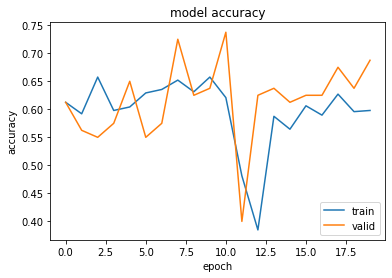

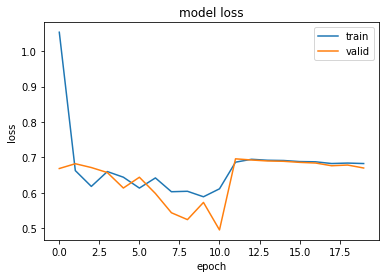

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

## NN1

Properties:

* Input layer
* Dense, 50 Neurons, ReLU
* Dense, 30 Neurons, ReLU
* Output layer, 1 Neuron, Sigmoid

* Binarycross entropy, SGD, Accuaracy

In [20]:
image_size = 150
num_train_images = 480
num_valid_images = 80
batch_size = 20

In [21]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[150,150,3])) ## make the array 1-D, Preprocessing
model.add(keras.layers.Dense(50, activation="relu")) ## 50 Neuronen
model.add(keras.layers.Dense(30, activation="relu")) ## 30 Neuronen
model.add(keras.layers.Dense(1, activation="sigmoid")) ## Eine Neuron pro Kategorie

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 67500)             0         
                                                                 
 dense_6 (Dense)             (None, 50)                3375050   
                                                                 
 dense_7 (Dense)             (None, 30)                1530      
                                                                 
 dense_8 (Dense)             (None, 1)                 31        
                                                                 
Total params: 3,376,611
Trainable params: 3,376,611
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.layers

In [24]:
model.compile(loss="binary_crossentropy", optimizer = "sgd", metrics = ["accuracy"])

In [25]:
name = f"basemodel_NN_ReLU + {time.time()}"
tensorboard = TensorBoard(log_dir=f"logs/{name}")


history = model.fit(
    train_generator,
    steps_per_epoch = num_train_images // batch_size,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = num_valid_images // batch_size,
    callbacks = tensorboard)

Epoch 1/20
24/24 [==============================] - 9s 378ms/step - loss: 0.9880 - accuracy: 0.6083 - val_loss: 0.8871 - val_accuracy: 0.3500
Epoch 2/20
24/24 [==============================] - 9s 366ms/step - loss: 0.6746 - accuracy: 0.6042 - val_loss: 0.6799 - val_accuracy: 0.5625
Epoch 3/20
24/24 [==============================] - 8s 327ms/step - loss: 0.6655 - accuracy: 0.6042 - val_loss: 0.6453 - val_accuracy: 0.6125
Epoch 4/20
24/24 [==============================] - 7s 299ms/step - loss: 0.6294 - accuracy: 0.6216 - val_loss: 0.5726 - val_accuracy: 0.7000
Epoch 5/20
24/24 [==============================] - 9s 355ms/step - loss: 0.6160 - accuracy: 0.6354 - val_loss: 0.5875 - val_accuracy: 0.6750
Epoch 6/20
24/24 [==============================] - 8s 335ms/step - loss: 0.6154 - accuracy: 0.6292 - val_loss: 0.7038 - val_accuracy: 0.6375
Epoch 7/20
24/24 [==============================] - 7s 297ms/step - loss: 0.6096 - accuracy: 0.6583 - val_loss: 0.6167 - val_accuracy: 0.6625
Epoch 

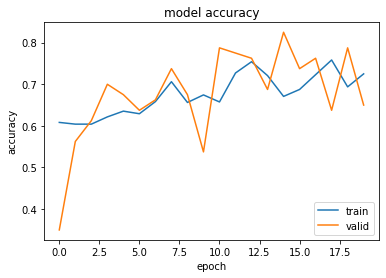

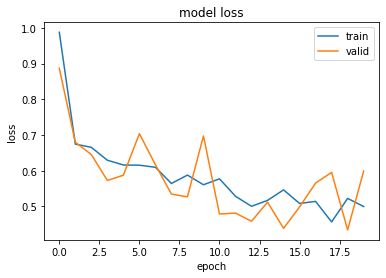

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

## NN2

Properties: The changed properties are highlighted

* Input layer
* Dense, 50 Neurons, **Tanh**
* Dense, 30 Neurons, **Tahn**
* Output layer, 1 Neuron, Sigmoid

* Binarycross entropy, SGD, Accuaracy

In [27]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[150,150,3])) ## make the array 1-D, Preprocessing
model.add(keras.layers.Dense(50, activation="tanh")) ## 50 Neuronen
model.add(keras.layers.Dense(30, activation="tanh")) ## 30 Neuronen
model.add(keras.layers.Dense(1, activation="sigmoid")) ## Eine Neuron pro Kategorie

In [28]:
model.compile(loss="binary_crossentropy", optimizer = "sgd", metrics = ["accuracy"])

In [29]:
name = f"basemodel_NN_Tanh + {time.time()}"
tensorboard = TensorBoard(log_dir=f"logs/{name}")

history = model.fit(
    train_generator,
    steps_per_epoch = num_train_images // batch_size,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = num_valid_images // batch_size,
    callbacks = tensorboard)

Epoch 1/20
24/24 [==============================] - 7s 265ms/step - loss: 0.8181 - accuracy: 0.5958 - val_loss: 0.7320 - val_accuracy: 0.5500
Epoch 2/20
24/24 [==============================] - 6s 238ms/step - loss: 0.6867 - accuracy: 0.5854 - val_loss: 0.7011 - val_accuracy: 0.5250
Epoch 3/20
24/24 [==============================] - 7s 278ms/step - loss: 0.6808 - accuracy: 0.5854 - val_loss: 0.6652 - val_accuracy: 0.6250
Epoch 4/20
24/24 [==============================] - 7s 278ms/step - loss: 0.6781 - accuracy: 0.5917 - val_loss: 0.6979 - val_accuracy: 0.5250
Epoch 5/20
24/24 [==============================] - 7s 293ms/step - loss: 0.6672 - accuracy: 0.6167 - val_loss: 0.6976 - val_accuracy: 0.5375
Epoch 6/20
24/24 [==============================] - 8s 338ms/step - loss: 0.6808 - accuracy: 0.5750 - val_loss: 0.6731 - val_accuracy: 0.6000
Epoch 7/20
24/24 [==============================] - 8s 333ms/step - loss: 0.6730 - accuracy: 0.5875 - val_loss: 0.6635 - val_accuracy: 0.6000
Epoch 

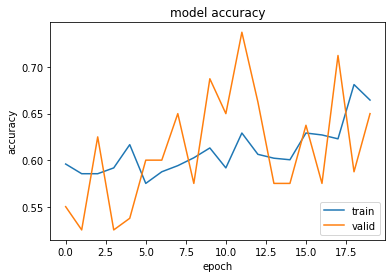

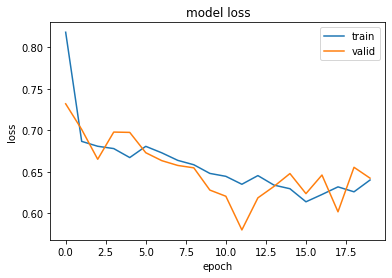

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

## NN3

Properties:

* Input layer
* **He-Initialisierung**
* Dense, 50 Neurons, **ReLU**
* Dense, 30 Neurons, **ReLU**
* Output layer, 1 Neuron, Sigmoid
* Binarycross entropy, SGD, Accuaracy

In [31]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[150,150,3])) ## make the array 1-D, Preprocessing
model.add(keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal")) ## 50 Neuronen
model.add(keras.layers.Dense(30, activation="relu", kernel_initializer="he_normal")) ## 30 Neuronen
model.add(keras.layers.Dense(1, activation="sigmoid")) ## Eine Neuron pro Kategorie

In [32]:
model.compile(loss="binary_crossentropy", optimizer = "sgd", metrics = ["accuracy"])

In [33]:
name = f"basemodel_NN_ReLU_He_normal + {time.time()}"
tensorboard = TensorBoard(log_dir=f"logs/{name}", histogram_freq=1)


history = model.fit(
    train_generator,
    steps_per_epoch = num_train_images // batch_size,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = num_valid_images // batch_size,
    callbacks = tensorboard)

Epoch 1/20
24/24 [==============================] - 8s 333ms/step - loss: 1.3081 - accuracy: 0.5271 - val_loss: 0.6937 - val_accuracy: 0.3500
Epoch 2/20
24/24 [==============================] - 8s 352ms/step - loss: 0.6911 - accuracy: 0.6173 - val_loss: 0.6892 - val_accuracy: 0.6250
Epoch 3/20
24/24 [==============================] - 10s 400ms/step - loss: 0.6879 - accuracy: 0.6208 - val_loss: 0.6877 - val_accuracy: 0.6000
Epoch 4/20
24/24 [==============================] - 8s 350ms/step - loss: 0.6854 - accuracy: 0.6195 - val_loss: 0.6877 - val_accuracy: 0.5750
Epoch 5/20
24/24 [==============================] - 8s 318ms/step - loss: 0.6865 - accuracy: 0.5854 - val_loss: 0.6882 - val_accuracy: 0.5625
Epoch 6/20
24/24 [==============================] - 8s 350ms/step - loss: 0.6824 - accuracy: 0.6131 - val_loss: 0.6771 - val_accuracy: 0.6500
Epoch 7/20
24/24 [==============================] - 8s 317ms/step - loss: 0.6782 - accuracy: 0.6313 - val_loss: 0.6832 - val_accuracy: 0.5875
Epoch

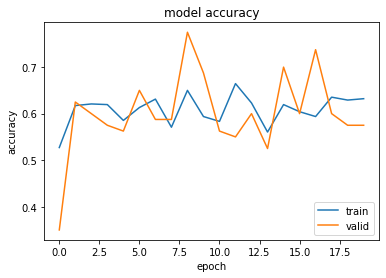

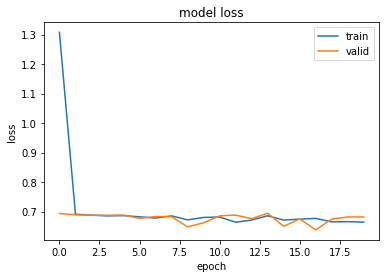

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

## NN4

Properties:

* Input layer
* He-Initialisierung
* Dense, 50 Neurons, **Leaky ReLU**
* Dense, 30 Neurons, **Leaky ReLU**
* Output layer, 1 Neuron, Sigmoid
* Binarycross entropy, SGD, Accuaracy

In [35]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[150,150,3])) ## make the array 1-D, Preprocessing
model.add(keras.layers.Dense(50, kernel_initializer="he_normal")) ## 50 Neuronen
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.Dense(30, kernel_initializer="he_normal")) ## 30 Neuronen
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.Dense(1, activation="sigmoid")) ## Eine Neuron pro Kategorie

In [36]:
model.compile(loss="binary_crossentropy", optimizer = "sgd", metrics = ["accuracy"])

In [37]:
name = f"basemodel_NN_LeakyReLU_He_normal + {time.time()}"
tensorboard = TensorBoard(log_dir=f"logs/{name}", histogram_freq=1)


history = model.fit(
    train_generator,
    steps_per_epoch = num_train_images // batch_size,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = num_valid_images // batch_size,
    callbacks = tensorboard)

Epoch 1/20
24/24 [==============================] - 8s 306ms/step - loss: 2.1121 - accuracy: 0.5437 - val_loss: 0.5679 - val_accuracy: 0.7000
Epoch 2/20
24/24 [==============================] - 8s 315ms/step - loss: 0.6814 - accuracy: 0.6021 - val_loss: 0.7017 - val_accuracy: 0.5625
Epoch 3/20
24/24 [==============================] - 6s 258ms/step - loss: 0.6809 - accuracy: 0.6000 - val_loss: 0.6273 - val_accuracy: 0.6250
Epoch 4/20
24/24 [==============================] - 5s 221ms/step - loss: 0.6172 - accuracy: 0.6500 - val_loss: 0.7322 - val_accuracy: 0.5500
Epoch 5/20
24/24 [==============================] - 6s 247ms/step - loss: 0.6045 - accuracy: 0.6512 - val_loss: 0.5825 - val_accuracy: 0.6625
Epoch 6/20
24/24 [==============================] - 6s 257ms/step - loss: 0.6304 - accuracy: 0.6146 - val_loss: 0.5886 - val_accuracy: 0.7875
Epoch 7/20
24/24 [==============================] - 7s 298ms/step - loss: 0.6004 - accuracy: 0.6771 - val_loss: 0.5580 - val_accuracy: 0.7500
Epoch 

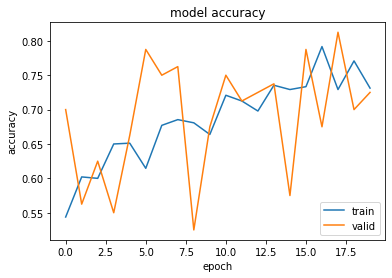

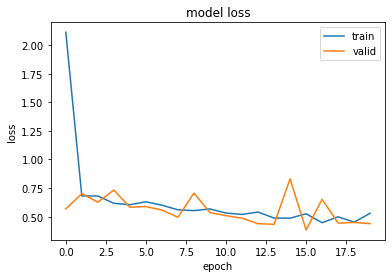

In [38]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

## NN5

Properties:

* Inputlayer
* **Batchnormalization** 
* He-Initialisierung
* Dense, 50 Neurons, Leaky ReLU
* Dense, 30 Neurons, Leaky ReLU
* Output layer, 1 Neuron, Sigmoid
* Binarycross entropy, SGD, Accuaracy

In [42]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[150,150,3])) ## make the array 1-D, Preprocessing
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(50, kernel_initializer="he_normal")) ## 50 Neuronen
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(30, kernel_initializer="he_normal")) ## 30 Neuronen
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1, activation="sigmoid")) ## Eine Neuron pro Kategorie

In [43]:
model.compile(loss="binary_crossentropy", optimizer = "sgd", metrics = ["accuracy"])

In [44]:
name = f"basemodel_NN_LeakyReLU_He_normal_batchnorm + {time.time()}"
tensorboard = TensorBoard(log_dir=f"logs/{name}", histogram_freq=1)

history = model.fit(
    train_generator,
    steps_per_epoch = num_train_images // batch_size,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = num_valid_images // batch_size,
    callbacks = tensorboard)

Epoch 1/20
24/24 [==============================] - 9s 349ms/step - loss: 0.5534 - accuracy: 0.7229 - val_loss: 0.8339 - val_accuracy: 0.6500
Epoch 2/20
24/24 [==============================] - 9s 362ms/step - loss: 0.4597 - accuracy: 0.7917 - val_loss: 0.5987 - val_accuracy: 0.7375
Epoch 3/20
24/24 [==============================] - 8s 350ms/step - loss: 0.4606 - accuracy: 0.7844 - val_loss: 0.6683 - val_accuracy: 0.6375
Epoch 4/20
24/24 [==============================] - 7s 278ms/step - loss: 0.4490 - accuracy: 0.8042 - val_loss: 0.6132 - val_accuracy: 0.7000
Epoch 5/20
24/24 [==============================] - 7s 271ms/step - loss: 0.4128 - accuracy: 0.8271 - val_loss: 0.6269 - val_accuracy: 0.5625
Epoch 6/20
24/24 [==============================] - 8s 321ms/step - loss: 0.3924 - accuracy: 0.8313 - val_loss: 0.4886 - val_accuracy: 0.6750
Epoch 7/20
24/24 [==============================] - 9s 365ms/step - loss: 0.3798 - accuracy: 0.8188 - val_loss: 0.4531 - val_accuracy: 0.6875
Epoch 

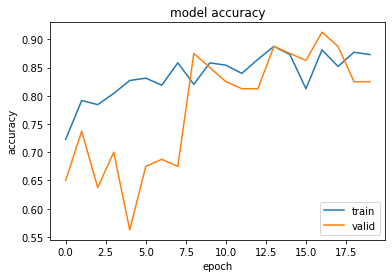

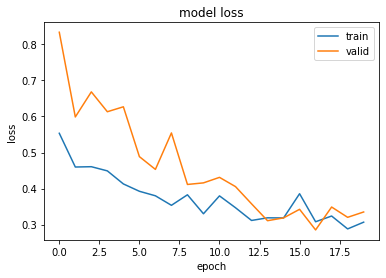

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

## NN6

Properties:

* Input layer
* Batchnormalization
* He-Initialisierung
* Dense, 50 Neurons, Leaky ReLU
* Dense, 30 Neurons, Leaky ReLU
* Output layer, 1 Neuron, Sigmoid
* Binarycross entropy, **Adam**, Accuaracy

In [46]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[150,150,3])) ## make the array 1-D, Preprocessing
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(50, kernel_initializer="he_normal")) ## 50 Neuronen
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(30, kernel_initializer="he_normal")) ## 30 Neuronen
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1, activation="sigmoid")) ## Eine Neuron pro Kategorie

In [47]:
model.compile(loss="binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [48]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 67500)             0         
                                                                 
 batch_normalization (BatchN  (None, 67500)            270000    
 ormalization)                                                   
                                                                 
 dense_10 (Dense)            (None, 50)                3375050   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 50)                0         
                                                                 
 batch_normalization_1 (Batc  (None, 50)               200       
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 30)               

In [48]:
name = f"bestmodel_NN_wo_dropout + {time.time()}"
tensorboard = TensorBoard(log_dir=f"logs/{name}", histogram_freq=1)

history = model.fit(
    train_generator,
    steps_per_epoch = num_train_images // batch_size,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = num_valid_images // batch_size,
    callbacks = tensorboard)

Epoch 1/20
24/24 [==============================] - 12s 460ms/step - loss: 0.5934 - accuracy: 0.7000 - val_loss: 2.2999 - val_accuracy: 0.6375
Epoch 2/20
24/24 [==============================] - 11s 460ms/step - loss: 0.4710 - accuracy: 0.7833 - val_loss: 1.7734 - val_accuracy: 0.5625
Epoch 3/20
24/24 [==============================] - 9s 389ms/step - loss: 0.4687 - accuracy: 0.7625 - val_loss: 1.0311 - val_accuracy: 0.6000
Epoch 4/20
24/24 [==============================] - 7s 306ms/step - loss: 0.3973 - accuracy: 0.8208 - val_loss: 0.6979 - val_accuracy: 0.6625
Epoch 5/20
24/24 [==============================] - 9s 353ms/step - loss: 0.4271 - accuracy: 0.7979 - val_loss: 0.7386 - val_accuracy: 0.5250
Epoch 6/20
24/24 [==============================] - 10s 407ms/step - loss: 0.3989 - accuracy: 0.8083 - val_loss: 0.5772 - val_accuracy: 0.6375
Epoch 7/20
24/24 [==============================] - 9s 372ms/step - loss: 0.4073 - accuracy: 0.7937 - val_loss: 0.5277 - val_accuracy: 0.6500
Epo

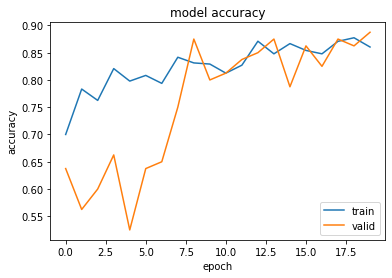

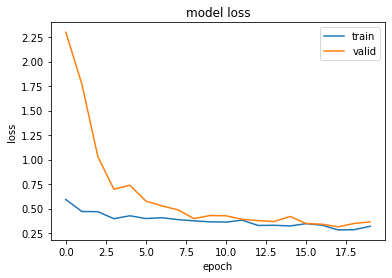

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [50]:
loss, accuracy = model.evaluate(test_generator)

16/16 [==============================] - 4s 222ms/step - loss: 0.3737 - accuracy: 0.8350


In [51]:
#model.save('C:/Users/Lars Hubacher/switchdrive/DeepLearninginVision/final/bestmodel_NN_wo_dropout.h5')

## Roc Curve

In [52]:
test_datagen = ImageDataGenerator(
        rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,  # this is the target directory
        target_size=(image_size, image_size),  # all images will be resized to 150x150
        classes=classes,
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='binary',
        shuffle=False)
## Shuffle False

Found 303 images belonging to 2 classes.


In [53]:
from sklearn.metrics import roc_curve, auc

In [54]:
y_pred_keras = model.predict(test_generator).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_generator.classes, y_pred_keras)
## False positive, True Postive, Thresholds

In [55]:
## Area under the curve
auc_keras = auc(fpr_keras, tpr_keras)

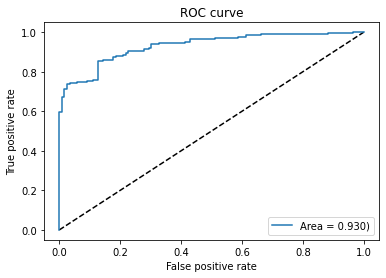

In [56]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Best Threshold


In [57]:
## calculate the g-mean for each threshold
## The geometric mean or known as G-mean is the geometric mean of sensitivity (known as recall) and specificity
gmeans = np.sqrt(tpr_keras * (1-fpr_keras))

In [58]:
## locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds_keras[ix], gmeans[ix]))

Best Threshold=0.748500, G-Mean=0.864


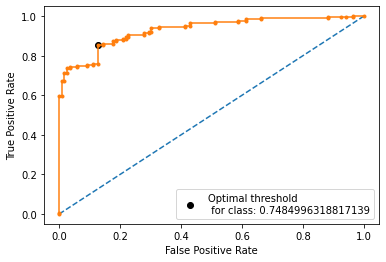

In [59]:
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr_keras, tpr_keras, marker='.')
plt.scatter(fpr_keras[ix], tpr_keras[ix], marker='o', color='black', label='Optimal threshold \n for class: {}'.format(thresholds_keras[ix]))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

## NN7

* Input layer
* Batchnormalization
* He-Initialisierung
* **Dropout of 20%**
* Dense, 50 Neurons, Leaky ReLU
* Dense, 30 Neurons, Leaky ReLU
* Output layer, 1 Neuron, Sigmoid
* Binarycross entropy, Adam, Accuaracy

In [60]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[150,150,3])) ## make the array 1-D, Preprocessing
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(50, kernel_initializer="he_normal")) ## 50 Neuronen
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(30, kernel_initializer="he_normal")) ## 30 Neuronen
model.add(keras.layers.LeakyReLU())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1, activation="sigmoid")) ## Eine Neuron pro Kategorie

In [61]:
model.compile(loss="binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [62]:
name = f"bestmodel_NN_with_dropout + {time.time()}"
tensorboard = TensorBoard(log_dir=f"logs/{name}")

history = model.fit(
    train_generator,
    steps_per_epoch = num_train_images // batch_size,
    epochs = 20,
    validation_data = validation_generator,
    validation_steps = num_valid_images // batch_size,
    callbacks=tensorboard)

Epoch 1/20
24/24 [==============================] - 11s 404ms/step - loss: 0.9047 - accuracy: 0.6875 - val_loss: 0.9554 - val_accuracy: 0.6000
Epoch 2/20
24/24 [==============================] - 8s 352ms/step - loss: 0.5875 - accuracy: 0.7250 - val_loss: 0.6358 - val_accuracy: 0.7125
Epoch 3/20
24/24 [==============================] - 8s 318ms/step - loss: 0.5256 - accuracy: 0.7526 - val_loss: 0.7048 - val_accuracy: 0.6375
Epoch 4/20
24/24 [==============================] - 8s 321ms/step - loss: 0.5063 - accuracy: 0.7463 - val_loss: 0.6819 - val_accuracy: 0.6625
Epoch 5/20
24/24 [==============================] - 7s 282ms/step - loss: 0.4714 - accuracy: 0.7750 - val_loss: 0.5564 - val_accuracy: 0.6250
Epoch 6/20
24/24 [==============================] - 8s 327ms/step - loss: 0.4832 - accuracy: 0.7437 - val_loss: 0.4819 - val_accuracy: 0.7750
Epoch 7/20
24/24 [==============================] - 8s 348ms/step - loss: 0.4298 - accuracy: 0.8021 - val_loss: 0.4965 - val_accuracy: 0.7000
Epoch

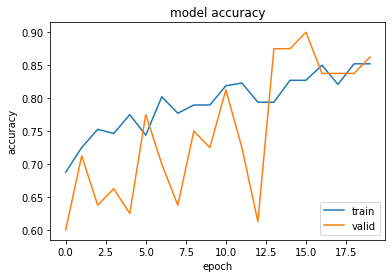

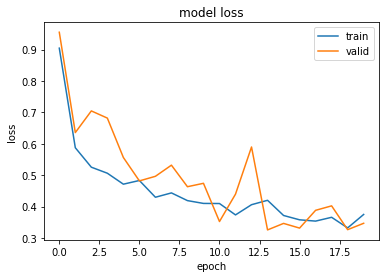

In [63]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [64]:
loss, accuracy = model.evaluate(test_generator)

16/16 [==============================] - 3s 208ms/step - loss: 0.3535 - accuracy: 0.8383


In [65]:
#model.save('C:/Users/Lars Hubacher/switchdrive/DeepLearninginVision/final/bestmodel_NN_with_dropout.h5')

## Roc Curve

In [66]:
test_datagen = ImageDataGenerator(
        rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_dir,  # this is the target directory
        target_size=(image_size, image_size),  # all images will be resized to 150x150
        classes=classes,
        batch_size=batch_size,
        color_mode='rgb',
        class_mode='binary',
        shuffle=False)
## Shuffle False

Found 303 images belonging to 2 classes.


In [67]:
from sklearn.metrics import roc_curve, auc

In [68]:
y_pred_keras = model.predict(test_generator).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(test_generator.classes, y_pred_keras)
## False positive, True Postive, Thresholds

In [69]:
## Area under the curve
auc_keras = auc(fpr_keras, tpr_keras)

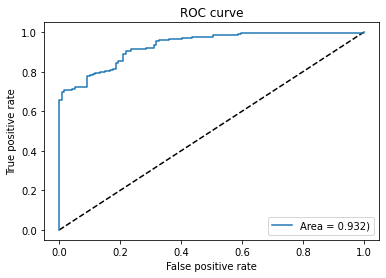

In [70]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Best Threshold

In [71]:
## calculate the g-mean for each threshold
## The geometric mean or known as G-mean is the geometric mean of sensitivity (known as recall) and specificity
gmeans = np.sqrt(tpr_keras * (1-fpr_keras))

In [72]:
## locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds_keras[ix], gmeans[ix]))

Best Threshold=0.535660, G-Mean=0.842


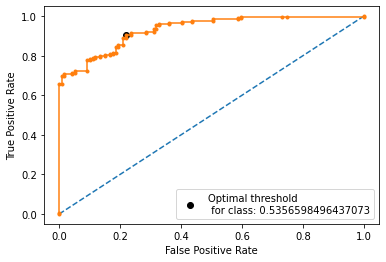

In [73]:
plt.plot([0,1], [0,1], linestyle='--')
plt.plot(fpr_keras, tpr_keras, marker='.')
plt.scatter(fpr_keras[ix], tpr_keras[ix], marker='o', color='black', label='Optimal threshold \n for class: {}'.format(thresholds_keras[ix]))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()